In [1]:
import gc
import os
import cv2
import math
import base64
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid

from torchmetrics import MeanMetric

from IPython.display import display, HTML, clear_output

# UNet Model

Materials are taken from https://learnopencv.com/denoising-diffusion-probabilistic-models/ and https://github.com/spmallick/learnopencv/blob/master/Guide-to-training-DDPMs-from-Scratch/Generating_MNIST_using_DDPMs.ipynb

In DDPMs, the authors use a UNet-shaped deep neural network which takes in as input:

1. The input image at any stage of the reverse process.

2. The timestep of the input image.

From the usual UNet architecture, the authors replaced the original double convolution at each level with “Residual blocks” used in ResNet models.

$\textbf{ The architecture comprises 5 components:}$

1. Encoder blocks

2. Bottleneck blocks

3. Decoder blocks

4. Self attention modules

5. Sinusoidal time embeddings

$\textbf{Architectural Details:}$

1. There are four levels in the encoder and decoder path with bottleneck blocks between them.

2. Each encoder stage comprises two residual blocks with convolutional downsampling except the last level.

3. Each corresponding decoder stage comprises three residual blocks and uses 2x nearest neighbors with convolutions to upsample the input from the previous level.

4. Each stage in the encoder path is connected to the decoder path with the help of skip connections. 

5. The model uses “Self-Attention” modules at a single feature map resolution. 

6. Every residual block in the model gets the inputs from the previous layer (and others in the decoder path) and the embedding of the current timestep. The timestep embedding informs the model of the input’s current position in the Markov chain.

![unet](/p/project/training2416/bazarova1/learnopencv/Guide-to-training-DDPMs-from-Scratch/denoising-diffusion-probabilistic-models_UNet_model_architecture.png)

We are working on an image size of (32×32). Only two minor changes exist between our model and the original model used in the paper. 

We use 64 base channels instead of 128.

There are four levels in both encoder and decoder paths. The feature maps size at each level are kept as follows: 32 →16 → 8 → 8. We are applying self-attention at feature map sizes of both (16x16) and (8x8) as opposed to the original, where they are applied just once at a feature map size of (16x16).


In [3]:

#the class to inform a model on the position of the timestep 

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        # Sinusoidal embedding for each time step and then defines a sequence of layers
        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        # sequence of layers to process the embedding

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)


#Attention block can help the model to focus on different parts of the input when making predictions.

class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels = channels

        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x) #Group Normalization to the input x.

        # Reshapes the normalized tensor and swaps axes to prepare it for the MHSA layer. 
        # The reshaping and swapping of axes is done to match the input shape requirement of the MHSA layer in PyTorch, 
        # which expects input in the shape [batch_size, sequence_length, embedding_dimension].
        
        h = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]

        # The MHSA layer. It's used in a self-attention configuration where the query, key, and value are all the same (i.e., h).

        h, _ = self.mhsa(h, h, h)  # [B, H*W, C]

        # The output of the MHSA layer is then reshaped and axes are swapped back to match the original input shape.
        h = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]

        # The output of the MHSA layer is then added to the input x (residual connection)
        return x + h


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.act_fn = nn.SiLU()
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h) # normalization and a convolution to the input x.

        # group 2
        
        # add in timestep embedding
        # The time embedding is processed through a linear layer and an activation function, and then broadcasted to match the shape of h.

        h += self.dense_1(self.act_fn(t))[:, :, None, None] 

        # group 3

        # Another normalization, dropout, and convolution are applied to h.
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)

        return h


class DownSample(nn.Module): 
    # downsamples the input approximately by half, reducing the height and width of the input image while preserving the number of channels.
    # belongs to the UNet encoder
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, *args):
        return self.downsample(x)


class UpSample(nn.Module):
    # upsamples the input approximately by double, increasing the height and width of the input image while preserving the number of channels.
    # belongs to the UNet decoder

    def __init__(self, in_channels):
        super().__init__()

        self.upsample = nn.Sequential(

        #Upsampling on the input. The mode="nearest" parameter means that the upsampling will be done using nearest neighbor upsampling, 
        #which simply replicates the input values in the upscaled output.
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x, *args):
        return self.upsample(x)


class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=3,
        num_res_blocks=2,
        base_channels=128,
        base_channels_multiples=(1, 2, 4, 8),
        apply_attention=(False, False, True, False),
        dropout_rate=0.1,
        time_multiple=4,
    ):
        super().__init__()

        time_emb_dims_exp = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels

        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks):

                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                self.encoder_blocks.append(block)

                in_channels = out_channels
                curr_channels.append(in_channels)

            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck in between
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t):

        time_emb = self.time_embeddings(t) #The time embedding is processed through the time embedding layers.

        h = self.first(x) #The input x is passed through the first convolutional layer.
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, time_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb)

        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)

        h = self.final(h)

        return h
    

Make sure we are using GPU if it is available

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# Helper Functions



In [5]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_default_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to("cpu").numpy()
    im = Image.fromarray(ndarr)
    im.save(path)
    
def get(element: torch.Tensor, t: torch.Tensor):
    """
    Get value at index position "t" in "element" and
        reshape it to have the same dimension as a batch of images.
    """
    ele = element.gather(-1, t)
    return ele.reshape(-1, 1, 1, 1)

def setup_log_directory(config):
    '''Log and Model checkpoint directory Setup'''
    
    if os.path.isdir(config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = config.log_dir

    # Update the training config default directory 
    log_dir        = os.path.join(config.root_log_dir,        version_name)
    checkpoint_dir = os.path.join(config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(log_dir,        exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"Logging at: {log_dir}")
    print(f"Model Checkpoint at: {checkpoint_dir}")
    
    return log_dir, checkpoint_dir

def frames2vid(images, save_path):

    WIDTH = images[0].shape[1]
    HEIGHT = images[0].shape[0]

#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     fourcc = 0
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(save_path, fourcc, 25, (WIDTH, HEIGHT))

    # Appending the images to the video one by one
    for image in images:
        video.write(image)

    # Deallocating memories taken for window creation
#     cv2.destroyAllWindows()
    video.release()
    return 

def display_gif(gif_path):
    b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
    display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

# Configurations

In [6]:
from dataclasses import dataclass

@dataclass
class BaseConfig:
    DEVICE = get_default_device()
    DATASET = "MNIST" #  "MNIST", "Cifar-10", "Cifar-100", "Flowers"
    
    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("Logs_Checkpoints", "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"

@dataclass
class TrainingConfig:
    TIMESTEPS = 1000 # Define number of diffusion timesteps
    IMG_SHAPE = (1, 32, 32) if BaseConfig.DATASET == "MNIST" else (3, 32, 32) 
    NUM_EPOCHS = 30
    BATCH_SIZE = 128
    LR = 2e-4
    NUM_WORKERS = 2

# Load Dataset & Build Dataloader

In [7]:
def get_dataset(dataset_name='MNIST'):
    transforms = TF.Compose(
        [
            TF.ToTensor(),
            TF.Resize((32, 32), 
                      interpolation=TF.InterpolationMode.BICUBIC, 
                      antialias=True),
#             TF.RandomHorizontalFlip(),
            TF.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
        ]
    )
    
    if dataset_name.upper() == "MNIST":
        dataset = datasets.MNIST(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-10":    
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-100":
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Flowers":
        dataset = datasets.ImageFolder(root="/kaggle/input/flowers-recognition/flowers", transform=transforms)
    
    return dataset

def get_dataloader(dataset_name='MNIST', 
                   batch_size=32, 
                   pin_memory=False, 
                   shuffle=True, 
                   num_workers=0, 
                   device=device
                  ):
    dataset    = get_dataset(dataset_name=dataset_name)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            pin_memory=pin_memory, 
                            num_workers=num_workers, 
                            shuffle=shuffle
                           )
    device_dataloader = DeviceDataLoader(dataloader, device)
    return device_dataloader

def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0 

# Visualize Dataset

In [8]:
loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=128,
    device=device,
)

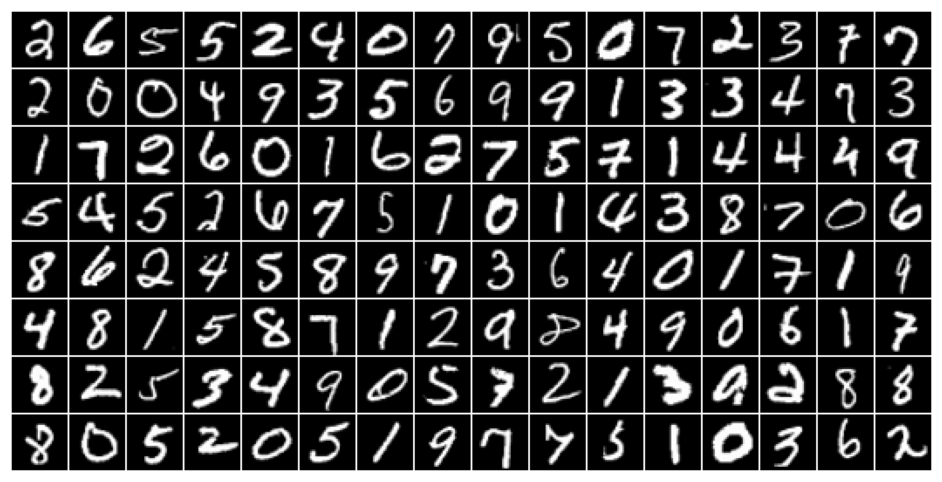

In [9]:
%matplotlib inline
plt.figure(figsize=(12, 6), facecolor='white')

for b_image, _ in loader:
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

# Diffusion Process

In this section, we are creating a class called SimpleDiffusion. This class contains:

1. Scheduler constants required for performing the forward and reverse diffusion process.

2. A method to define the linear variance scheduler used in DDPMs.

3. A method that performs a single step using the updated forward diffusion kernel.

Computes $\beta_t$, $\alpha_t$, $\bar{\alpha}_t=\prod \alpha_t$, $1/\sqrt{\alpha_t}$, $\sqrt{1-\bar{\alpha}_t}$, $\sqrt{\bar{\alpha}_t}$


In [10]:
class SimpleDiffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 64, 64),
        device="cuda:0",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device

        self.initialize()

    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta
        
        self_sqrt_beta                       = torch.sqrt(self.beta)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)
         
    def get_betas(self):
        """linear schedule, proposed in original ddpm paper"""
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )
        


## Python Code For Forward Diffusion Process

In this section, we are writing the python code to perform the “forward diffusion process” in a single step as per the equation mentioned here.

The `forward_diffusion(...)` function takes in a batch of images and corresponding timesteps and adds noise/corrupts the input images using the updated forward diffusion kernel equation.

Computes $x_t=\sqrt{\bar{\alpha}_t}x_0+\sqrt{1-\bar{\alpha_t}}\varepsilon,\quad \varepsilon\sim\mathcal{N}(0,{\bf I}),\quad \bar{\alpha_t}=\prod_{t=1}^t\alpha_i$

In [11]:
def forward_diffusion(sd: SimpleDiffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    eps = torch.randn_like(x0)  # Noise
    mean    = get(sd.sqrt_alpha_cumulative, t=timesteps) * x0  # Image scaled
    std_dev = get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps) # Noise scaled
    sample  = mean + std_dev * eps # scaled inputs * scaled noise

    return sample, eps  # return ... , gt noise --> model predicts this)

## Sample Forward Diffusion Process

In this section, we’ll visualize the forward diffusion process on some sample images to see how they get corrupted as they pass through the Markov chain for T timesteps.

In [13]:
sd = SimpleDiffusion(num_diffusion_timesteps=TrainingConfig.TIMESTEPS, device=device)

loader = iter(  # converting dataloader into an iterator for now.
    get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=6,
        device=device,
    )
)

Performing the forward process for some specific timesteps and also storing the noisy versions of the original image.

In [14]:
x0s, _ = next(loader)

noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)
    timestep=timestep.to(device)

    xts, _ = forward_diffusion(sd, x0s, timestep)
    xts    = inverse_transform(xts) / 255.0
    xts    = make_grid(xts, nrow=1, padding=1)
    
    noisy_images.append(xts)


The original image gets increasingly corrupted as timesteps increase. At the end of the forward process, we are left with noise.

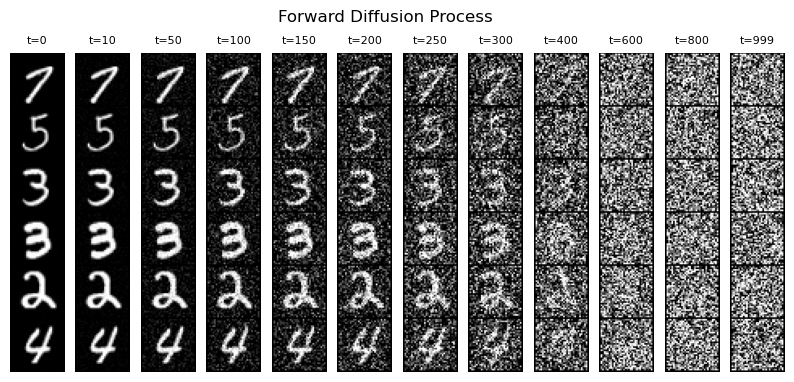

In [15]:
# Plot and see samples at different timesteps

_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.detach().cpu().squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()

# Training & Sampling Algorithms Used In Denoising Diffusion Probabilistic Models

![algo](/p/project/training2416/bazarova1/learnopencv/Guide-to-training-DDPMs-from-Scratch/denoising-diffusion-probabilistic-models_DDPM_trainig_inference_algorithm.png)

$\textbf{Training code based on Algorithm 1:}$

The first function defined here is `train_one_epoch(...)`. This function is used for performing “one epoch of training ” i.e., it trains the model by iterating once over the entire dataset and will be called in our final training loop.

We also use **Mixed-Precision** training to train the model faster and save GPU memory. The code is pretty straightforward and almost a one-to-one conversion from the algorithm.

In [18]:
# Algorithm 1: Training

def train_one_epoch(model, sd, loader, optimizer, scaler, loss_fn, epoch=800, 
                   base_config=BaseConfig(), training_config=TrainingConfig()):
    
    loss_record = MeanMetric()
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{training_config.NUM_EPOCHS}")
         
        for x0s, _ in loader:
            tq.update(1)
            
            #generating timesteps for the forward diffusion process
            ts = torch.randint(low=1, high=training_config.TIMESTEPS, size=(x0s.shape[0],), device=base_config.DEVICE)

            #corrupted images and ground truth noise
            xts, gt_noise = forward_diffusion(sd, x0s, ts)

            with amp.autocast(): # Mixed Precision Training
                #predicted noise at timestep ts
                pred_noise = model(xts, ts)
                loss = loss_fn(gt_noise, pred_noise)

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()
    
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
    
    return mean_loss 

$\textbf{Sampling or Inference code based on Algorithm 2:}$

The next function we define is `reverse_diffusion(...)` which is responsible for performing inference i.e., generating images using the reverse diffusion process. The function takes in a trained model and the diffusion class and can either generate a video showcasing the entire diffusion process or just the final generated image. 

Computes $\frac1{\sqrt{\alpha_t}}(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\varepsilon_{\theta}(x_t,t))$

In [20]:
# Algorithm 2: Sampling
    
@torch.inference_mode()
def reverse_diffusion(model, sd, timesteps=1000, img_shape=(3, 64, 64), 
                      num_images=5, nrow=8, device="cpu", **kwargs):

    x = torch.randn((num_images, *img_shape), device=device)
    model.eval()

    if kwargs.get("generate_video", False):
        outs = []

    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        predicted_noise = model(x, ts)

        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts) 

        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        ) #exactly the formula above

        if kwargs.get("generate_video", False):
            x_inv = inverse_transform(x).type(torch.uint8)
            grid = torchvision.utils.make_grid(x_inv, nrow=nrow, pad_value=255.0).to("cpu")
            ndarr = torch.permute(grid, (1, 2, 0)).numpy()[:, :, ::-1]
            outs.append(ndarr)

    if kwargs.get("generate_video", False): # Generate and save video of the entire reverse process. 
        frames2vid(outs, kwargs['save_path'])
        display(Image.fromarray(outs[-1][:, :, ::-1])) # Display the image at the final timestep of the reverse process.
        return None

    else: # Display and save the image at the final timestep of the reverse process. 
        x = inverse_transform(x).type(torch.uint8)
        grid = torchvision.utils.make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
        pil_image = TF.functional.to_pil_image(grid)
        pil_image.save(kwargs['save_path'], format=save_path[-3:].upper())
        display(pil_image)
        return None

# Training DDPMs From Scratch

In the previous sections, we have already defined all the necessary classes and functions required for training. All we have to do now is assemble them and start the training process. 

Before we begin training:

- We’ll first define all the model-related hyperparameters.
- Then initialize the **UNet** model,  **AdamW** optimizer, **MSEloss** function, and other necessary classes.

In [14]:
@dataclass
class ModelConfig:
    BASE_CH = 64  # 64, 128, 256, 512
    BASE_CH_MULT = (1, 2, 4, 8) # 32, 16, 8, 4 
    APPLY_ATTENTION = (False, False, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 2 # 128

In [15]:
model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
model.to(BaseConfig.DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR)

dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    pin_memory    = True,
    num_workers   = TrainingConfig.NUM_WORKERS,
)

loss_fn = nn.MSELoss()

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

scaler = amp.GradScaler()

/p/software/jusuf/stages/2024/software/PyTorch/2.1.2-gcccoreflexiblas-12.3.0-3.3.1/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Then we’ll initialize the logging and checkpoint directories to save intermediate sampling results and model parameters

In [16]:
total_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir, checkpoint_dir = setup_log_directory(config=BaseConfig())

generate_video = False
ext = ".mp4" if generate_video else ".png"

Logging at: Logs_Checkpoints/Inference/version_2
Model Checkpoint at: Logs_Checkpoints/checkpoints/version_2


Finally, we can write our training loop. As we have divided all our code into simple, easy-to-debug functions and classes, all we have to do now is call them in the epochs training loop. Specifically, we need to call the “training” and “sampling” functions defined in the previous section in a loop.

Sampling :: 100%|██████████| 999/999 [00:17<00:00, 57.71it/s]


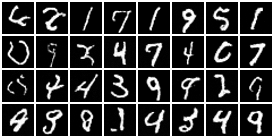

Sampling :: 100%|██████████| 999/999 [00:17<00:00, 57.81it/s]


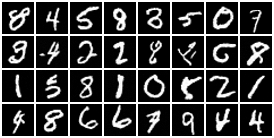

Sampling :: 100%|██████████| 999/999 [00:17<00:00, 57.90it/s]


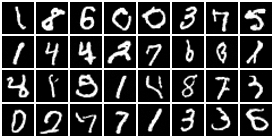

Sampling :: 100%|██████████| 999/999 [00:17<00:00, 57.92it/s]


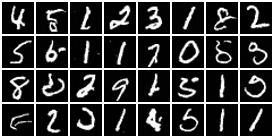

Sampling :: 100%|██████████| 999/999 [00:17<00:00, 57.87it/s]


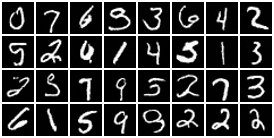

Sampling :: 100%|██████████| 999/999 [00:17<00:00, 57.90it/s]


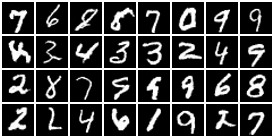

In [17]:
for epoch in range(1, total_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    
    # Algorithm 1: Training
    train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch)

    if epoch % 5 == 0:
        save_path = os.path.join(log_dir, f"{epoch}{ext}")
        
        # Algorithm 2: Sampling
        reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS, num_images=32, generate_video=generate_video,
            save_path=save_path, img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.DEVICE,
        )

        # clear_output()
        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
        }
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.tar"))
        del checkpoint_dict

# Generating Images Using DDPMs (Inference)

You can let the training complete for 800 epochs or interrupt in between if you are satisfied with the samples generated at every 20 epochs. 

To perform the **inference**, we simply have to reload the saved model, and you can use the same or a different logging directory to save the results. You can re-initialize the `SimpleDiffusion` class as well, but it’s not necessary.

In [18]:
model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
# checkpoint_dir = "/kaggle/working/Logs_Checkpoints/checkpoints/version_0"


model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ckpt.tar"), map_location='cpu')['model'])

model.to(BaseConfig.DEVICE)

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

The inference code is simply a call to the `reverse_diffusion(...)` function using the trained model.

Sampling :: 100%|██████████| 999/999 [00:28<00:00, 35.36it/s]


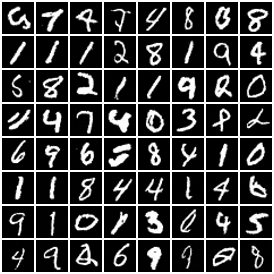

inference_results/20240518-175516.mp4


In [19]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=64,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=8,
)
print(save_path)

Sampling :: 100%|██████████| 999/999 [01:35<00:00, 10.42it/s]


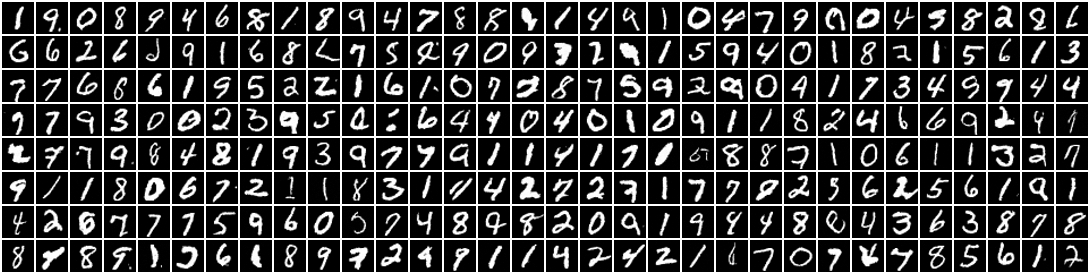

inference_results/20240518-175619.mp4


In [20]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=256,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=32,
)
print(save_path)

Sampling :: 100%|██████████| 999/999 [04:04<00:00,  4.08it/s]


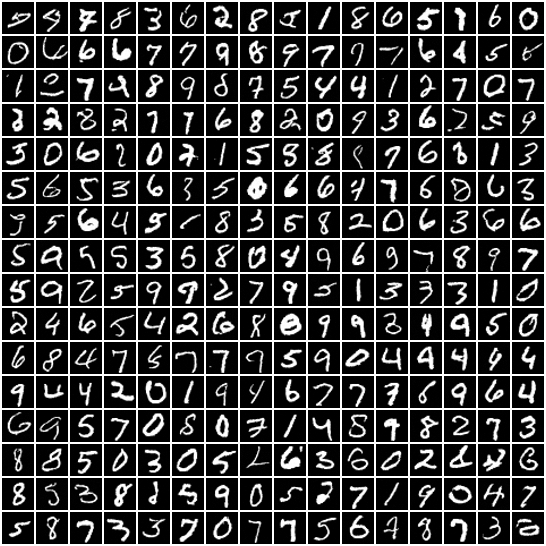

inference_results/20230222-161659.mp4


In [24]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=256,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=16,
)
print(save_path)

Sampling :: 100%|██████████| 999/999 [04:04<00:00,  4.08it/s]


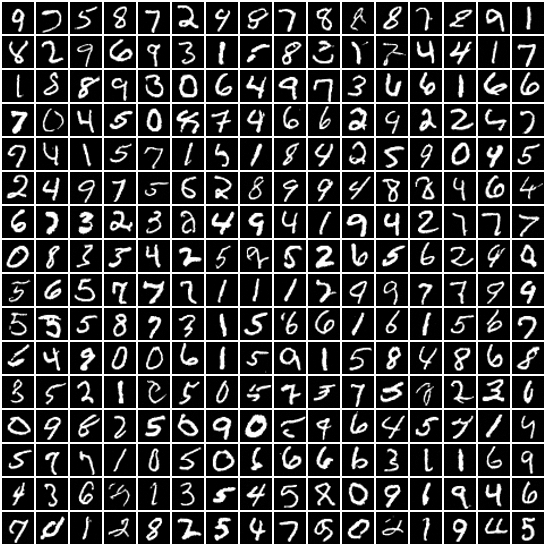

inference_results/20230222-163005.mp4


In [28]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=256,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=16,
)
print(save_path)

Sampling :: 100%|██████████| 999/999 [07:45<00:00,  2.15it/s]


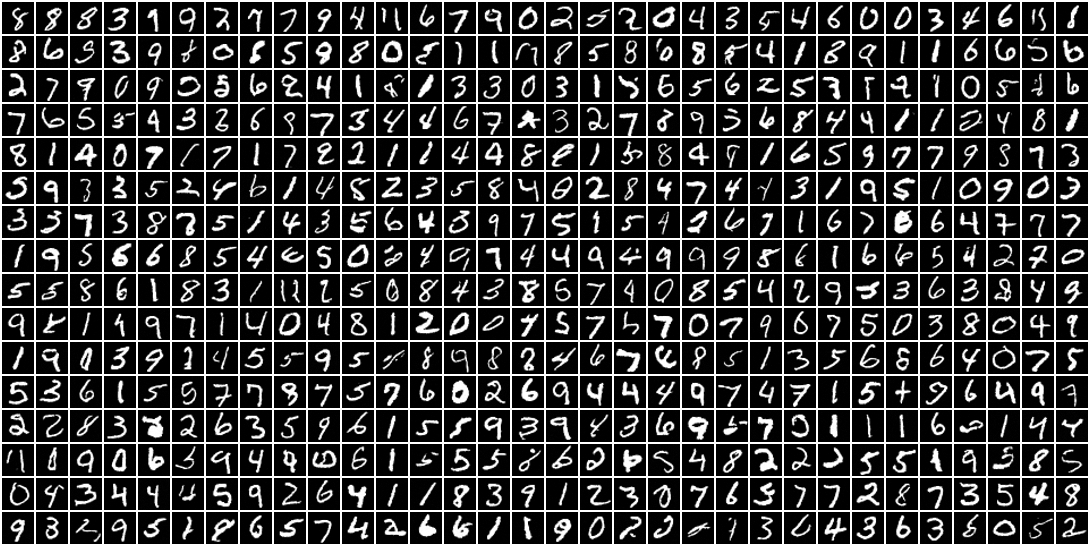

inference_results/20230222-163416.mp4


In [29]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=512,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=32,
)
print(save_path)

Sampling :: 100%|██████████| 999/999 [00:25<00:00, 39.22it/s]


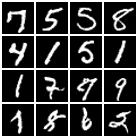

inference_results/20230222-161633.mp4


In [23]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=16,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=4,
)
print(save_path)

inference_results/20230222-162111.mp4


Sampling :: 100%|██████████| 999/999 [02:20<00:00,  7.11it/s]


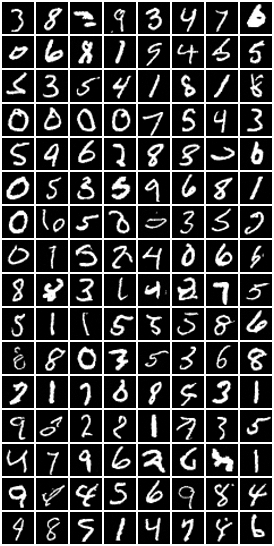

inference_results/20230222-162111.mp4


In [25]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)
print(save_path)

reverse_diffusion(
    model,
    sd,
    num_images=128,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=8,
)
print(save_path)

inference_results/20230222-162335.mp4


Sampling :: 100%|██████████| 999/999 [04:04<00:00,  4.08it/s]


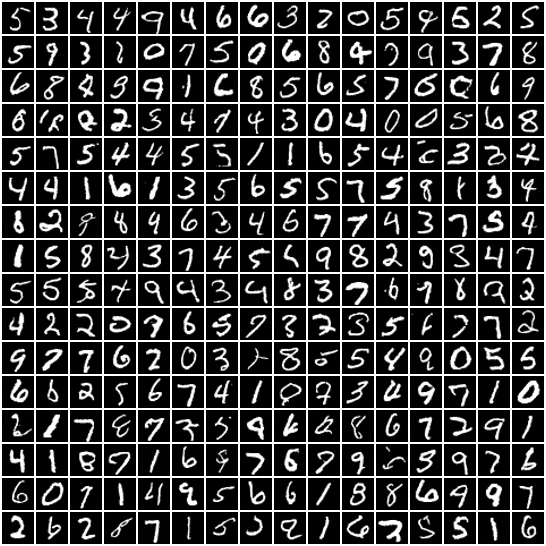

inference_results/20230222-162335.mp4


In [26]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)
print(save_path)

reverse_diffusion(
    model,
    sd,
    num_images=256,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=16,
)
print(save_path)

Sampling :: 100%|██████████| 999/999 [02:17<00:00,  7.24it/s]


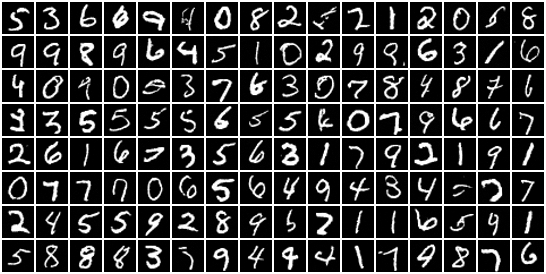

inference_results/20230222-162747.png


In [27]:
generate_video = False

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)


reverse_diffusion(
    model,
    sd,
    num_images=128,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=16,
)
print(save_path)